In [1]:
!kaggle datasets download -d spsayakpaul/bitresnet101x3flowers102

bitresnet101x3flowers102.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!unzip -qq bitresnet101x3flowers102.zip

replace T-r101x3-128/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tf.version.VERSION

2023-01-01 20:12:10.190244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.11.0'

In [4]:
@dataclass
class Config:
    BATCH_SIZE = 24

    # Comes from Table 4 and "Training setup" section.
    TEMPERATURE = 2  # Used to soften the logits before they go to softmax.
    INIT_LR = 0.01  # Initial learning rate that will be decayed over the training period.
    WEIGHT_DECAY = 1e-5  # Used for regularization.
    CLIP_THRESHOLD = 1.0  # Used for clipping the gradients by L2-norm.

    # We will first resize the training images to a bigger size and then we will take
    # random crops of a lower size.
    BIGGER = 160
    RESIZE = 128
    EPOCHS = 300


config = Config()

In [5]:
data = tfds.load("oxford_flowers102", as_supervised=True)

print(f"Number of training examples: {data['train'].cardinality()}.")
print(f"Number of validation examples: {data['validation'].cardinality()}.")
print(f"Number of test examples: {data['test'].cardinality()}.")

Number of training examples: 1020.
Number of validation examples: 1020.
Number of test examples: 6149.


2023-01-01 20:12:12.833292: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [6]:
teacher_model = keras.models.load_model("./T-r101x3-128")
teacher_model.trainable = False
teacher_model.summary()

2023-01-01 20:12:28.530031: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 're_lu_99/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 2 outputs. Output shapes may be inaccurate.
2023-01-01 20:12:28.530084: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'global_average_pooling2d/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 4 outputs. Output shapes may be inaccurate.


Model: "my_bi_t_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             multiple                  626790    
                                                                 
 keras_layer_1 (KerasLayer)  multiple                  381789888 
                                                                 
Total params: 382,416,678
Trainable params: 0
Non-trainable params: 382,416,678
_________________________________________________________________


In [7]:
generator = tf.random.Generator.from_seed(666)


def mixup(images, labels):
    alpha = generator.uniform([], 0.9, 1.0)
    mixedup_images = alpha * images + (1 - alpha) * tf.reverse(images, axis=[0])
    return mixedup_images, labels


def preprocess(training=True):
    def f(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        if training:
            image = tf.image.resize(image, (config.BIGGER, config.BIGGER))
            image = tf.image.random_crop(image, (config.RESIZE, config.RESIZE, 3))
            image = tf.image.random_flip_left_right(image)
        else:
            # Central fraction amount is from here:
            # https://git.io/J8Kda.
            image = tf.image.central_crop(image, central_fraction=0.875)
            image = tf.image.resize(image, (config.RESIZE, config.RESIZE))
        return image, label
    
    return f


train_ds = data['train'].shuffle(config.BATCH_SIZE * 10).map(preprocess()).batch(config.BATCH_SIZE)
validation_ds = data['validation'].map(preprocess(False)).batch(config.BATCH_SIZE)
test_ds = data['test'].map(preprocess(False)).batch(config.BATCH_SIZE)

train_ds = train_ds.map(mixup)

train_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

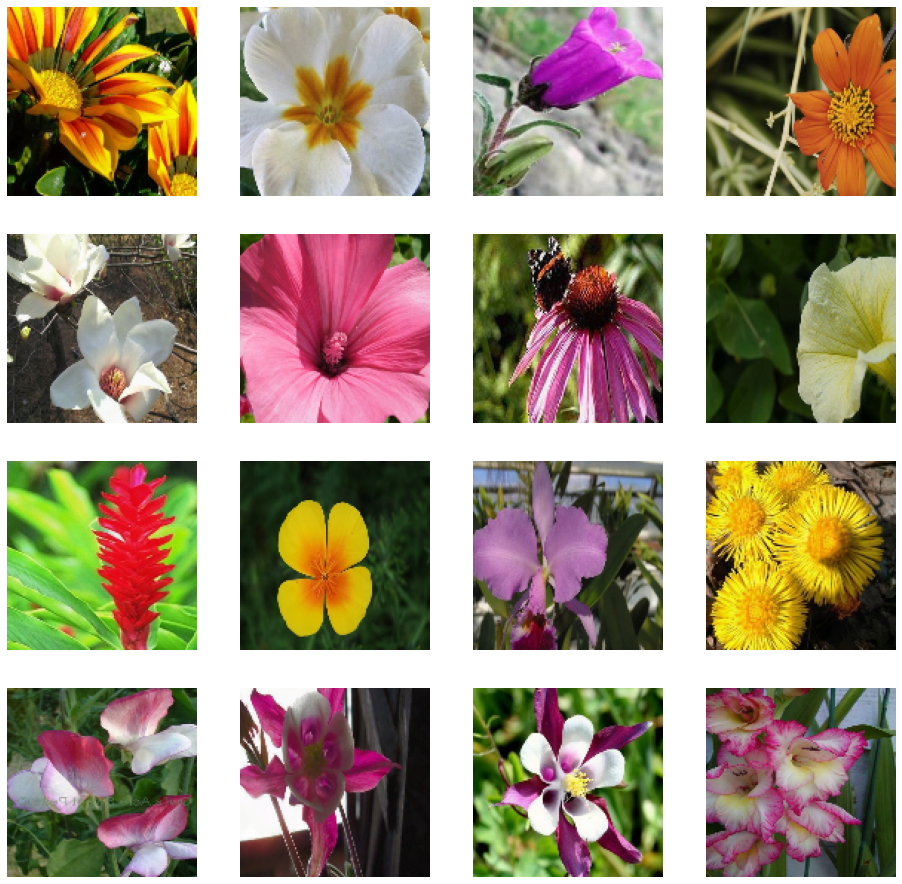

In [8]:
def show_images(ds):
    plt.figure(figsize=(16, 16))
    for images, labels in ds:
        for j in range(16):
            ax = plt.subplot(4, 4, j+1)
            plt.imshow(images[j].numpy())
            plt.axis('off')
        plt.show()
        break


show_images(train_ds)

In [9]:
def get_resnetv2():
    resnet_v2 = keras.applications.ResNet50V2(
        weights=None,
        input_shape=(config.RESIZE, config.RESIZE, 3),
        classes=102,
        classifier_activation="linear",
    )
    return resnet_v2


student_model = get_resnetv2()
student_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_conv[0][0]']    

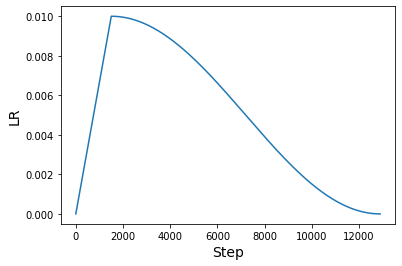

In [10]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )



TOTAL_STEPS = len(train_ds) * config.EPOCHS
scheduled_lrs = WarmUpCosine(
    learning_rate_base=config.INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=0.0,
    warmup_steps=1500,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [11]:
class Distiller(keras.Model):
    def __init__(self, teacher, student):
        super(Distiller, self).__init__()
        
        self.teacher = teacher
        self.student = student
        self.loss_tracker = keras.metrics.Mean(name='distillation_loss')
    
    @property
    def metrics(self):
        m = super().metrics
        m.append(self.loss_tracker)
        return m
    
    def compile(self, optimizer, metrics, distillation_loss_fn):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.distillation_loss_fn = distillation_loss_fn
    
    def train_step(self, data):
        x, _ = data
        
        teacher_prediction = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            student_prediction = self.student(x, training=True)
            
            distillation_loss = self.distillation_loss_fn(
                teacher_prediction / config.TEMPERATURE,
                student_prediction / config.TEMPERATURE)
            distillation_loss = tf.nn.compute_average_loss(
                distillation_loss, global_batch_size=config.BATCH_SIZE)
        
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(distillation_loss, trainable_vars)
        
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_tracker.update_state(distillation_loss)
        return {'distillation_loss': self.loss_tracker.result()}
    
    def test_step(self, data):
        x, y = data
        
        teacher_prediction = self.teacher(x, training=False)
        student_prediction = self.student(x, training=False)
        distillation_loss = self.distillation_loss_fn(
            teacher_prediction / config.TEMPERATURE,
            student_prediction / config.TEMPERATURE)
        distillation_loss = tf.nn.compute_average_loss(
            distillation_loss, global_batch_size=config.BATCH_SIZE)
        
        self.loss_tracker.update_state(distillation_loss)
        self.compiled_metrics.update_state(y, student_prediction)
        results = {m.name: m.result() for m in self.metrics}
        return results


def kl_divergence(true_p, q):
    true_prob = tf.nn.softmax(true_p, axis=-1)
    loss_1 = -tf.nn.softmax_cross_entropy_with_logits(logits=true_p, labels=true_prob)
    loss_2 = tf.nn.softmax_cross_entropy_with_logits(logits=q, labels=true_prob)   
    loss = loss_1 + loss_2
    return loss


distiller = Distiller(teacher=teacher_model, student=student_model)
optimizer = tfa.optimizers.AdamW(
    weight_decay=config.WEIGHT_DECAY,
    learning_rate=scheduled_lrs,
    clipnorm=config.CLIP_THRESHOLD)
# optimizer = keras.optimizers.Adam(scheduled_lrs)

distiller.compile(
    optimizer,
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    distillation_loss_fn=kl_divergence)

history = distiller.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=config.EPOCHS)

Epoch 1/300


2023-01-01 20:13:01.181446: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-01 20:13:01.281057: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-01 20:13:01.358644: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-01 20:13:01.520768: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

43/43 [==============================] - 42s 692ms/step - distillation_loss: 0.6147 - val_sparse_categorical_accuracy: 0.0098 - val_distillation_loss: 0.5092
Epoch 2/300
43/43 [==============================] - 25s 596ms/step - distillation_loss: 0.5570 - val_sparse_categorical_accuracy: 0.0196 - val_distillation_loss: 0.6097
Epoch 3/300
43/43 [==============================] - 26s 599ms/step - distillation_loss: 0.5489 - val_sparse_categorical_accuracy: 0.0235 - val_distillation_loss: 0.7515
Epoch 4/300
43/43 [==============================] - 26s 602ms/step - distillation_loss: 0.5306 - val_sparse_categorical_accuracy: 0.0373 - val_distillation_loss: 1.0561
Epoch 5/300
43/43 [==============================] - 26s 603ms/step - distillation_loss: 0.5260 - val_sparse_categorical_accuracy: 0.0333 - val_distillation_loss: 1.2502
Epoch 6/300
43/43 [==============================] - 26s 602ms/step - distillation_loss: 0.5100 - val_sparse_categorical_accuracy: 0.0255 - val_distillation_loss:

KeyboardInterrupt: 

In [ ]:
student_model.compile(metrics=["accuracy"])
_, top1_accuracy = student_model.evaluate(test_ds)
print(top1_accuracy)

In [ ]:
student_model.save('student.h5')